# Classification

In [1]:
#!usr/bin/env python3

# Basic import
import numpy as np
import matplotlib.pyplot as plt

# Pytorch import
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset, Subset
from torchvision import transforms, datasets
import torch.nn.functional as F

# Import models and training functions
from models import ConvNet, FFNet
from training import train_epoch, val_epoch
from functions import my_accuracy

# Import progress bars
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
from time import sleep


## Dataset and Dataloader

In [2]:
### Dataset

dataset = datasets.MNIST('MNIST', train = True, download = True,
                             transform = transforms.Compose([
                               transforms.ToTensor()
                             ]))

test_data = datasets.MNIST('MNIST', train = False, download = True,
                             transform=transforms.Compose([
                               transforms.ToTensor()
                             ]))

# Divide data dataset in train dataset and val dataset
train_data, val_data = torch.utils.data.random_split(dataset, [50000, 10000])

In [3]:
### Dataloaders
train_dataloader = DataLoader(train_data, batch_size = 100, shuffle = True, num_workers=0)
val_dataloader = DataLoader(val_data, batch_size = 100, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_data, batch_size = 1, shuffle=True, num_workers=0)

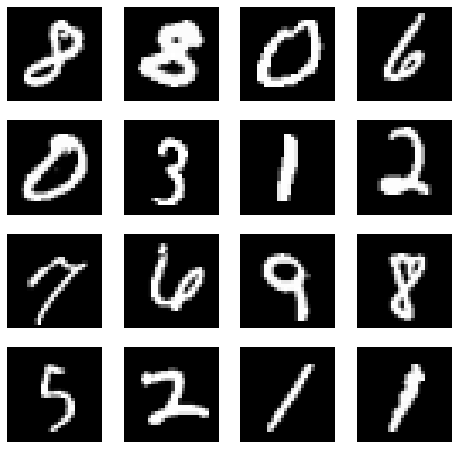

In [4]:
# Plot Mnist
figure = plt.figure(figsize=(8, 8))
cols, rows = 4,4


for i in range(1,cols * rows+1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Define the network

In [5]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cpu


In [6]:
# Define the pytorch_lightning networks
parameters1 = {
    "act" : "ReLU", 
    "optimizer" : "Adam", 
    "loss_fn" : "CrossEntropyLoss",
    "lr" : 1e-3, 
    "L2_reg" : 0.0, 
    "drop_p" : 0.1,
}

parameters2 = {
    "act" : "ReLU", 
    "optimizer" : "RMSprop", 
    "loss_fn" : "CrossEntropyLoss",
    "lr" : 1e-3, 
    "L2_reg" : 0.0, 
    "drop_p" : 0.1,
}

parameters3 = {
    "act" : "ReLU", 
    "optimizer" : "SGD", 
    "loss_fn" : "CrossEntropyLoss",
    "lr" : 1e-3, 
    "L2_reg" : 0.0, 
    "drop_p" : 0.1,
}


torch.manual_seed(0)
net = ConvNet(parameters1)
net.to(device)

Network initialized


ConvNet(
  (cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.1, inplace=False)
  )
  (lin): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

## Training

In [ ]:
# Define the loss function
loss_function = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr = 1e-4, weight_decay = 0.0)

In [ ]:
### Training loop
num_epochs = 50

# Pogress bar
pbar = tqdm_notebook(range(num_epochs))

# Inizialize empty lists to save losses
train_loss_log = []
val_loss_log = []

for epoch_num in pbar:
    # Tran epoch
    mean_train_loss = train_epoch(net, device, train_dataloader, loss_function, optimizer)

    # Validate epoch
    mean_val_loss = val_epoch(net,  device, val_dataloader, loss_function)

    # Append losses
    train_loss_log.append(mean_train_loss)
    val_loss_log.append(mean_val_loss)

    # Set pbar description
    pbar.set_description("Train loss: %s" %round(mean_train_loss,2)+","+"Validation loss %s" %round(mean_val_loss,2))
    

    

In [ ]:
### Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

## Save and load model

In [ ]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
net_dict = { "state" : net.state_dict(),
            "parameters" : parameters1}
# Save the state dict to a file
torch.save(net_dict,'ConvNet_parameters.torch')


In [7]:
### Reload the network state

# Load the state dict previously saved
net_dict = torch.load('ConvNet_parameters.torch')
net_state_dict = net_dict["state"]
net_parameters_dict = net_dict["parameters"]

# Redefine the network and upload parameters
net = ConvNet(net_parameters_dict)
net.load_state_dict(net_state_dict)

Network initialized


<All keys matched successfully>

# Network analysis

## Accuracy
    
    

In [8]:
### Compute accuracy of the model
mismatched, confusion, acc = my_accuracy(net, device, test_dataloader)
print("Test accuracy: ", acc, "%")

Test accuracy:  99.11 %


### Plot mismatched numbers


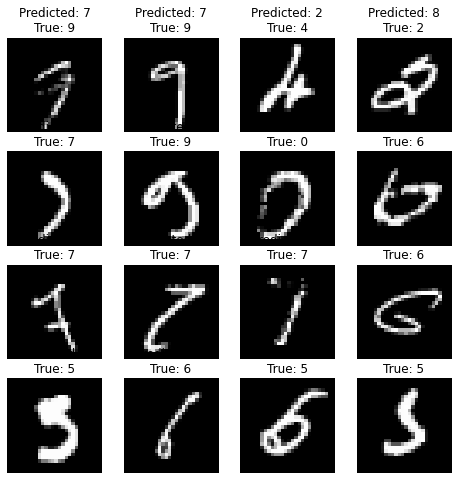

In [13]:
# Plot Mismatched numbers
figure = plt.figure(figsize=(8, 8))
cols, rows = 4,4


for i in range(rows*cols):
    img = mismatched[i][0]
    
    figure.add_subplot(rows, cols, i+1)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray"  )
    plt.title("Predicted: "+str(mismatched[i][1])+"\n"+"True: "+str(mismatched[i][2]))
plt.show()

### Confusion matrix

In [ ]:
# Build the confusion matrix

## Network parameters 

In [ ]:
# Access convolution network parameters

dense_weight = net.lin[0].weight.data.cpu().numpy()
dense_bias = net.lin[0].bias.data.cpu().numpy()
out_weight = net.lin[3].weight.data.cpu().numpy()
out_bias = net.lin[3].bias.data.cpu().numpy()

### Convolution filtered images

In [ ]:
# Acces convolution filters
conv1 = net.cnn[0].weight.data.cpu()
conv2 = net.cnn[4].weight.data.cpu()

In [ ]:
### First convolution filter
fig = plt.figure(figsize=(8, 8))
cols, rows = 4,4

# Take an image and apply convolution
img, label = train_data[0]
img = F.conv2d(img.unsqueeze(dim=0), conv1)

# Plot filtered images

for i in range(16):
    fig.add_subplot(rows, cols, i+1)
    plt.axis("off")
    #plt.title("Filter %d" %(i+1))
    plt.imshow(img.squeeze().numpy()[i], cmap="gray")
    
plt.tight_layout()
plt.show()




In [ ]:
### Second convolution filter
fig = plt.figure(figsize=(8, 8))
cols, rows = 8,4

# Take an image and apply convolution
img, label = train_data[9]
img = F.conv2d(img.unsqueeze(dim=0), conv1)
img = F.relu(img)
img  = F.max_pool2d(img, kernel_size = 2)
img = F.conv2d(img, conv2)

# Plot filtered images

for i in range(32):
    fig.add_subplot(rows, cols, i+1)
    plt.axis("off")
    #plt.title("Filter %d" %(i+1))
    plt.imshow(img.squeeze().numpy()[i], cmap="gray")
    
plt.tight_layout()
plt.show()